## Disease embedding and clustering of monocyte derived macrophages

This notebook subsets to monocyte derived macrophages from disease extension data to generate a UMAP and cluster.

#### Structure

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

In [1]:
%load_ext autoreload
%autoreload 2
import importlib

In [2]:
spam_spec = importlib.util.find_spec("lab_black")
if spam_spec is not None:
    %load_ext lab_black

In [3]:
# basic modules
import os, re, time
import sys, warnings

In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
# in-house/developing modules
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
7b32b9a39ad70713acde__mypyc NA
PIL                         9.2.0
autoreload                  NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
black                       22.6.0
blib2to3                    NA
cffi                        1.15.1
click                       8.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
h5py                        3.7.0
igraph                      0.9.11
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  8.0.2
jedi                        0.18.2
joblib                      1.1.0
jupyter_server              1.23.4
kiwisolver                  1.4.4
lab_black                   NA
leidenalg                   0.8.10
llvmlite       

In [7]:
print("Environment:", re.sub(".os.py", "", os.__file__))
parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
print("Working at:", re.sub(parentpath(os.getcwd(), 2), "", os.getcwd()))

Environment: /home/icb/ciro.suastegui/miniconda3/envs/HLCA_basic/lib/python3.7
Working at: /notebooks/4_disease_analysis


### Global variables and paths

In [8]:
adata_inp = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"
annot_inp = "../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
edata_inp = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_full.h5ad"
adata_comb_out = (
    "../../data/HLCA_extended/extension_disease/scarches_emb_MdM_full-matrix.h5ad"
)

### Loading data <a class="anchor" id="bullet2"></a>

In [9]:
embed = sc.read(adata_inp)

In [10]:
embed

AnnData object with n_obs × n_vars = 2382658 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'l

In [11]:
edata = sc.read(edata_inp, backed="r")

In [12]:
edata

AnnData object with n_obs × n_vars = 2382658 × 59586 backed at '../../data/HLCA_extended/HLCA_extended/HLCA_extended_full.h5ad'
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_

In [13]:
annot_pred = pd.read_csv(annot_inp, index_col=0)

In [14]:
annot_pred

,most_confident_level,most_confident_uncert,most_confident_label,transf_ann_level_5_uncert,transf_ann_level_5_label,transf_ann_level_4_uncert,transf_ann_level_4_label,transf_ann_level_3_uncert,transf_ann_level_3_label,transf_ann_level_2_uncert,transf_ann_level_2_label,transf_ann_level_1_uncert,transf_ann_level_1_label
001C_AAACCTGCATCGGGTC_adams,Level_3,0.000000e+00,Monocytes,1.400267e-01,4_Non-classical monocytes,1.400267e-01,Non-classical monocytes,0.000000e+00,Monocytes,0.000000e+00,Myeloid,0.000000e+00,Immune
001C_AAACCTGTCAACACCA_adams,Level_4,0.000000e+00,Alveolar macrophages,2.600470e-01,4_Alveolar macrophages,0.000000e+00,Alveolar macrophages,0.000000e+00,Macrophages,0.000000e+00,Myeloid,0.000000e+00,Immune
001C_AAACCTGTCACAGTAC_adams,Level_2,5.960464e-08,Lymphoid,2.200202e-01,4_NK cells,2.200202e-01,NK cells,2.200202e-01,Innate lymphoid cell NK,5.960464e-08,Lymphoid,5.960464e-08,Immune
001C_AAACCTGTCTGTCTAT_adams,Level_2,0.000000e+00,Myeloid,2.799665e-01,Monocyte-derived Mph,2.599604e-01,Interstitial macrophages,2.399455e-01,Macrophages,0.000000e+00,Myeloid,0.000000e+00,Immune
001C_AAACGGGAGACTAAGT_adams,Level_5,5.960464e-08,3_Lymphatic EC mature,5.960464e-08,3_Lymphatic EC mature,5.960464e-08,3_Lymphatic EC mature,5.960464e-08,Lymphatic EC mature,5.960464e-08,Lymphatic EC,5.960464e-08,Endothelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCGGAATTC-1_DD073R_tata_unpubl,Level_3,0.000000e+00,Fibroblasts,5.998033e-02,4_Alveolar fibroblasts,5.998033e-02,Alveolar fibroblasts,0.000000e+00,Fibroblasts,0.000000e+00,Fibroblast lineage,0.000000e+00,Stroma
TTTGGAGAGGATTTAG-1_DD073R_tata_unpubl,Level_2,0.000000e+00,Smooth muscle,6.000769e-02,3_Smooth muscle FAM83D+,6.000769e-02,3_Smooth muscle FAM83D+,6.000769e-02,Smooth muscle FAM83D+,0.000000e+00,Smooth muscle,0.000000e+00,Stroma
TTTGGTTCACGACGCT-1_DD073R_tata_unpubl,Level_2,0.000000e+00,Fibroblast lineage,1.199936e-01,4_Peribronchial fibroblasts,1.199936e-01,Peribronchial fibroblasts,2.001530e-02,Fibroblasts,0.000000e+00,Fibroblast lineage,0.000000e+00,Stroma
TTTGGTTGTGATACAA-1_DD073R_tata_unpubl,Level_5,0.000000e+00,4_Alveolar fibroblasts,0.000000e+00,4_Alveolar fibroblasts,0.000000e+00,Alveolar fibroblasts,0.000000e+00,Fibroblasts,0.000000e+00,Fibroblast lineage,0.000000e+00,Stroma


### Pre-processing <a class="anchor" id="bullet3"></a>

In [15]:
index_intersect = list(set(embed.obs.index) & set(annot_pred.index))
print("Intersection with prediction:", len(index_intersect))
embed.obs.core_or_extension.value_counts()

Intersection with prediction: 1797714


extension    1797714
core          584944
Name: core_or_extension, dtype: int64

Getting the columns we need for the annotation at different levels.

In [16]:
temp = [not i in embed.obs.columns for i in annot_pred.columns]
embed.obs = pd.concat([embed.obs, annot_pred.loc[index_intersect, temp]], axis=1)

Filling up core labels in each level of the transfer columns.

In [17]:
for column_i in list(
    filter(re.compile(r"transf_ann_level_._label").search, embed.obs.columns)
):
    print("--------------------", column_i)
    embed.obs[column_i] = embed.obs[column_i].astype(str)
    embed.obs[re.sub("transf_|_label", "", column_i)] = embed.obs[
        re.sub("transf_|_label", "", column_i)
    ].astype(str)
    temp = embed.obs[column_i] == "nan"
    embed.obs["celltype"] = embed.obs[column_i]
    embed.obs.loc[temp, "celltype"] = embed.obs.loc[
        temp, re.sub("transf_|_label", "", column_i)
    ]
    embed.obs[column_i] = embed.obs["celltype"]

-------------------- transf_ann_level_1_label
-------------------- transf_ann_level_2_label
-------------------- transf_ann_level_3_label
-------------------- transf_ann_level_4_label
-------------------- transf_ann_level_5_label


In [18]:
embed.obs[
    [column_i, re.sub("transf_|_label", "", column_i), "celltype", "core_or_extension"]
]

,transf_ann_level_5_label,ann_level_5,celltype,core_or_extension
GCGACCATCCCTAACC_SC22,4_Alveolar macrophages,4_Alveolar macrophages,4_Alveolar macrophages,core
P2_1_GCGCAACCAGTTAACC,4_NK cells,4_NK cells,4_NK cells,core
GCTCTGTAGTGCTGCC_SC27,3_AT2,3_AT2,3_AT2,core
P2_8_TTAGGACGTTCAGGCC,Alveolar Mph CCL3+,Alveolar Mph CCL3+,Alveolar Mph CCL3+,core
CTTGATTGTCAGTTTG_T164,4_Suprabasal,4_Suprabasal,4_Suprabasal,core
...,...,...,...,...
TTTGATCTCGGAATTC-1_DD073R_tata_unpubl,4_Alveolar fibroblasts,nan,4_Alveolar fibroblasts,extension
TTTGGAGAGGATTTAG-1_DD073R_tata_unpubl,3_Smooth muscle FAM83D+,nan,3_Smooth muscle FAM83D+,extension
TTTGGTTCACGACGCT-1_DD073R_tata_unpubl,4_Peribronchial fibroblasts,nan,4_Peribronchial fibroblasts,extension
TTTGGTTGTGATACAA-1_DD073R_tata_unpubl,4_Alveolar fibroblasts,nan,4_Alveolar fibroblasts,extension


Now including the core and extensions.

In [19]:
embed_obs = embed.obs.copy()

We're only focusing on the **M**onocyte **d**erived **M**acrophages (MdM).

In [20]:
pd.set_option("display.max_rows", 500)
temp = embed_obs.transf_ann_level_5_label.value_counts()
temp[[i for i, s in enumerate(temp.index) if re.search("macro|Mph", s)]]

4_Alveolar macrophages           337565
Monocyte-derived Mph             203219
Alveolar Mph CCL3+                23332
Interstitial Mph perivascular     21005
Alveolar Mph proliferating         6460
Alveolar Mph MT-positive           2952
Name: transf_ann_level_5_label, dtype: int64

In [21]:
embed_celltype_obs = embed_obs[
    embed_obs.transf_ann_level_5_label.isin(["Monocyte-derived Mph"])
]

Removing datasets and condition that are not well represented (keeping >50 cells).

In [22]:
n_condition = embed_celltype_obs.condition.value_counts()
n_condition

Healthy                                      66505
IPF                                          49066
COVID-19                                     43386
COVID-19 severe                              11681
Systemic sclerosis-associated ILD             9052
Healthy (tumor adjacent)                      4099
Squamous Cell Carcinoma                       3184
Lung adenocarcinoma                           2964
Myositis-associated ILD                       2336
Pneumonia non-COVID                           1951
COPD                                          1945
HP                                            1761
Large Cell Carcinoma                          1328
NSIP                                          1085
ILD                                            885
End-stage lung fibrosis, unknown etiology      747
Sarcoidosis                                    518
Lymphangioleiomyomatosis                       266
COVID-19 moderate                              200
Chronic rhinitis               

In [23]:
n_dataset = embed_celltype_obs.dataset.value_counts()
n_dataset

Kaminski_2020                62861
Banovich_Kropski_2020        23986
Budinger_2020                16062
Zhang_2021                   12434
Regev_2021_Nuclei             8606
Wunderink_2021_cryo           8347
Lambrechts_2021               7207
Misharin_Budinger_2018        6994
Thienpont_2018_10Xv2          6394
Meyer_2021_5prime             5840
Lafyatis_2019                 5661
Sheppard_2020                 4892
Wunderink_2021_fresh          4559
Misharin_2021                 4173
Lafyatis_Rojas_2019_10Xv2     4028
Meyer_2019                    2202
Teichmann_Meyer_2019          2062
Janssen_2020                  1980
Duong_lungMAP_unpubl          1551
Schiller_2021                 1461
Eils_2020                     1385
Sun_2020_batch3               1356
Sun_2020_batch1               1075
Schiller_2020                 1059
Peer_Massague_2020            1048
Sun_2020_batch4                995
Lafyatis_Rojas_2019_10Xv1      681
Krasnow_2020                   662
Tata_unpubl         

In [24]:
embed_celltype_obs = embed_celltype_obs[
    embed_celltype_obs.condition.isin(
        n_condition[n_condition > 50].index.tolist()
    ).tolist()
    and embed_celltype_obs.dataset.astype(str)
    .isin(n_dataset[n_dataset > 50].index.tolist())
    .tolist()
]

In [25]:
embed_filtered = embed[embed_celltype_obs.index].copy()

In [26]:
embed_filtered

AnnData object with n_obs × n_vars = 203150 × 30
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 'lo

Transefered celltypes are independent across levels.

In [27]:
pd.crosstab(
    embed_filtered.obs.transf_ann_level_5_label, embed_filtered.obs.core_or_extension
)

core_or_extension,core,extension
transf_ann_level_5_label,,
Monocyte-derived Mph,28156,174994


Combining embedding and full-matrix objects

In [28]:
barcodes = embed_filtered.obs_names.intersection(edata.obs_names)

In [29]:
%%time
adata_comb = edata[barcodes].to_memory()

CPU times: user 9.85 s, sys: 34.6 s, total: 44.5 s
Wall time: 52.9 s


Add missing columns found in embedding to the full-matrix object

In [30]:
temp = [i for i in embed_filtered.obs.columns if not i in adata_comb.obs.columns]
df = embed_filtered.obs.loc[:, temp]
print(f"Adding {df.shape[1]} more columns")
adata_comb.obs = pd.concat([adata_comb.obs, df], axis=1)

Adding 4 more columns


In [31]:
adata_comb

AnnData object with n_obs × n_vars = 203150 × 59586
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 

We need the embedding itself to run the neighbours, UMAP, and clustering.

In [32]:
adata_comb.obsm["X_scanvi"] = embed_filtered.X.copy()

Normalizing and log-transforming

In [33]:
sc.pp.normalize_total(
    adata_comb, target_sum=7699
)  # 7699 is median total counts across HLCA

In [34]:
sc.pp.log1p(adata_comb)

Renaming superfluous conditions and merging major groups.

In [35]:
condition_simplifier = {cond: cond for cond in adata_comb.obs.condition.unique()}
condition_simplifier

{'Healthy': 'Healthy',
 'Healthy (tumor adjacent)': 'Healthy (tumor adjacent)',
 'IPF': 'IPF',
 'COPD': 'COPD',
 'COVID-19': 'COVID-19',
 'Lymphangioleiomyomatosis': 'Lymphangioleiomyomatosis',
 'ILD': 'ILD',
 'Sarcoidosis': 'Sarcoidosis',
 'NSIP': 'NSIP',
 'HP': 'HP',
 'Squamous Cell Carcinoma': 'Squamous Cell Carcinoma',
 'Lung adenocarcinoma': 'Lung adenocarcinoma',
 'Large Cell Carcinoma': 'Large Cell Carcinoma',
 'Pleiomorphic Carcinoma': 'Pleiomorphic Carcinoma',
 'COVID-19 moderate': 'COVID-19 moderate',
 'COVID-19 severe': 'COVID-19 severe',
 'End-stage lung fibrosis, unknown etiology': 'End-stage lung fibrosis, unknown etiology',
 'Chronic rhinitis': 'Chronic rhinitis',
 'Systemic sclerosis-associated ILD': 'Systemic sclerosis-associated ILD',
 'Myositis-associated ILD': 'Myositis-associated ILD',
 'Pneumonia non-COVID': 'Pneumonia non-COVID'}

In [36]:
condition_simplifier.update(
    {
        "COVID-19 moderate": "COVID-19",
        "COVID-19 severe": "COVID-19",
        "Healthy (tumor adjacent)": "Healthy",
        "Large Cell Carcinoma": "Carcinoma",
        "Lung adenocarcinoma": "Carcinoma",
        "Pleiomorphic Carcinoma": "Carcinoma",
        "Squamous Cell Carcinoma": "Carcinoma",
        "HP": "ILD",
        "Myositis-associated ILD": "ILD",
        "NSIP": "ILD",
        "Systemic sclerosis-associated ILD": "ILD",
        "Healthy (tumor adjacent)": "Healthy",
        "End-stage lung fibrosis, unknown etiology": "ILD",
        "Chronic rhinitis": "Other diseases",
        "Lymphangioleiomyomatosis": "Other diseases",
        "Sarcoidosis": "Other diseases",
    }
)

There are two samples (one subject) in the Schiller_2020 data that are End-stage Fibrosis but not IPF.

In [37]:
schiller_subjects = (
    adata_comb.obs.loc[adata_comb.obs.study == "Schiller_2020"]
    .subject_ID.astype(str)
    .unique()
    .tolist()
)
schiller_subjects = set(schiller_subjects) - set(["muc8257", "muc8258"])
indexes = adata_comb.obs["subject_ID"].isin(schiller_subjects) & adata_comb.obs[
    "condition"
].isin(["End-stage lung fibrosis, unknown etiology", "IPF"])
adata_comb.obs.loc[indexes, "condition"] = "IPF"

In [38]:
adata_comb.obs["condition_merged"] = (
    adata_comb.obs["condition"].map(condition_simplifier).astype("category")
)

### Main <a class="anchor" id="bullet4"></a>

Calculate UMAP.

In [39]:
%%time
sc.pp.neighbors(adata_comb, use_rep="X_scanvi", n_neighbors=30)

CPU times: user 1min 27s, sys: 599 ms, total: 1min 28s
Wall time: 1min 5s


In [40]:
%%time
sc.tl.umap(adata_comb)

CPU times: user 6min 17s, sys: 17.7 s, total: 6min 35s
Wall time: 5min 20s


#### Clustering

In [41]:
%%time
sc.tl.leiden(adata_comb, resolution=0.3, key_added="leiden_0.3")

CPU times: user 5min 26s, sys: 3.41 s, total: 5min 30s
Wall time: 5min 31s


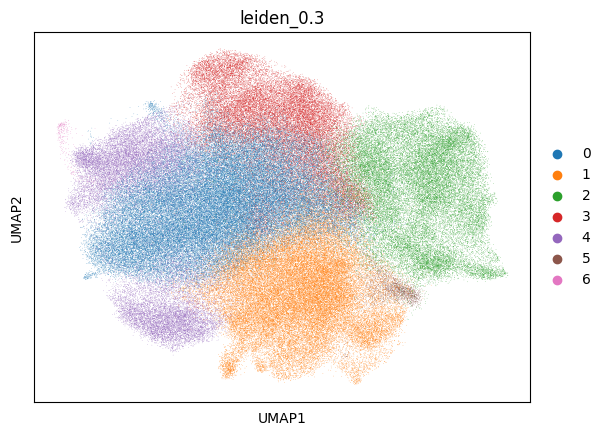

In [42]:
sc.pl.umap(adata_comb, color="leiden_0.3")

### Save <a class="anchor" id="bullet6"></a>

In [43]:
adata_comb

AnnData object with n_obs × n_vars = 203150 × 59586
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 

In [45]:
adata_comb.write(filename=adata_comb_out)

Task was destroyed but it is pending!
task: <Task pending coro=<Kernel.poll_control_queue() running at /home/icb/ciro.suastegui/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel/kernelbase.py:279> wait_for=<Future finished result=[<zmq.sugar.fr...x7f23ecee8ad0>, <zmq.sugar.fr...x7f23ecee8b90>, <zmq.sugar.fr...x7f23ecee8c50>, <zmq.sugar.fr...x7f23ecee8710>, <zmq.sugar.fr...x7f23ecee8950>, <zmq.sugar.fr...x7f23ecee8a10>, ...]> cb=[_chain_future.<locals>._call_set_state() at /home/icb/ciro.suastegui/miniconda3/envs/HLCA_basic/lib/python3.7/asyncio/futures.py:358]>


Done.